<a href="https://colab.research.google.com/github/Doppler-67/hotel-false-booking-detection/blob/main/hotel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Цель проекта:**

Нужно разработать систему, которая предсказывает отказ от брони. Если модель покажет, что бронь будет отменена, то клиенту предлагается внести депозит. Размер депозита — 80% от стоимости номера за одни сутки и затрат на разовую уборку.

**Описание данных:**

Доступны данные по бронированию номеров в сети отелей за три года.


⭕ *Более подробная информация находится в README файле.*  

# **Importing libraries**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import datetime
import math
import shap

from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import OrdinalEncoder
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
sns.set()

In [3]:
pd.set_option("display.max_columns", None)

# **Data understanding**

In [4]:
data = pd.read_csv('/content/drive/MyDrive/hotel_ds_project/data.csv')

In [5]:
data.head()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,meal,country,distribution_channel,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,reserved_room_type,booking_changes,days_in_waiting_list,customer_type,required_car_parking_spaces,total_of_special_requests,total_nights
0,0,0,7.0,2015,July,27,1,0,1,1.0,0.0,0.0,BB,GBR,Direct,0,0,0,A,0,0,Transient,0,0,1
1,1,0,14.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,GBR,TA/TO,0,0,0,A,0,0,Transient,0,1,2
2,2,0,0.0,2015,July,27,1,0,2,2.0,0.0,0.0,BB,PRT,Direct,0,0,0,C,0,0,Transient,0,0,2
3,3,0,9.0,2015,July,27,1,0,2,2.0,0.0,0.0,FB,PRT,Direct,0,0,0,C,0,0,Transient,0,1,2
4,4,1,85.0,2015,July,27,1,0,3,2.0,0.0,0.0,BB,PRT,TA/TO,0,0,0,A,0,0,Transient,0,1,3


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97641 entries, 0 to 97640
Data columns (total 25 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              97641 non-null  int64  
 1   is_canceled                     97641 non-null  int64  
 2   lead_time                       97641 non-null  float64
 3   arrival_date_year               97641 non-null  int64  
 4   arrival_date_month              97641 non-null  object 
 5   arrival_date_week_number        97641 non-null  int64  
 6   arrival_date_day_of_month       97641 non-null  int64  
 7   stays_in_weekend_nights         97641 non-null  int64  
 8   stays_in_week_nights            97641 non-null  int64  
 9   adults                          97641 non-null  float64
 10  children                        97641 non-null  float64
 11  babies                          97641 non-null  float64
 12  meal                            

In [7]:
data.describe()

,id,is_canceled,lead_time,arrival_date_year,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,babies,is_repeated_guest,previous_cancellations,previous_bookings_not_canceled,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,total_nights
count,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000,97641.000000
mean,49050.280456,0.375201,96.752839,2016.144243,26.846581,15.784455,0.839361,2.263066,1.843887,0.077836,0.006667,0.028554,0.089972,0.128860,0.201729,2.314642,0.053195,0.560902,3.102426
std,28234.038292,0.484177,93.045823,0.706299,13.772847,8.754660,0.853682,1.362798,0.483393,0.337358,0.091790,0.166549,0.797737,1.530961,0.609830,15.224212,0.228000,0.783654,1.739882
min,0.000000,0.000000,0.000000,2015.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,24673.000000,0.000000,19.000000,2016.000000,16.000000,8.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000
50%,49083.000000,0.000000,68.000000,2016.000000,27.000000,16.000000,1.000000,2.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,73493.000000,1.000000,152.000000,2017.000000,38.000000,23.000000,2.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,4.000000
max,97903.000000,1.000000,374.000000,2017.000000,53.000000,31.000000,4.000000,6.000000,4.000000,3.000000,10.000000,1.000000,26.000000,72.000000,18.000000,259.000000,8.000000,5.000000,10.000000


# **Data preparation**

Пропусков нет.

Так как колонка id это просто номер записи, а не id пользоватея, то никакой пользы она в себе не несет. Поэтому удалим ее.

In [8]:
data = data.drop('id', axis=1)

Проверим наличие дубликатов.

In [9]:
len(data[data.duplicated()])

29094

Удалим дубликаты.

In [10]:
data = data.drop_duplicates()

In [11]:
data['is_canceled'] = data['is_canceled'].astype(bool)
data['is_repeated_guest'] = data['is_repeated_guest'].astype(bool)

In [12]:
data['reserved_room_type'].unique()

array(['A               ', 'C               ', 'D               ',
       'E               ', 'G               ', 'F               ',
       'B               '], dtype=object)

In [13]:
data['meal'].unique()

array(['BB       ', 'FB       ', 'HB       ', 'SC       ', 'SC'],
      dtype=object)

В столбцах reserved_room_type и meal есть пробелы в строках. Уберем их.

In [14]:
data['reserved_room_type'] = data['reserved_room_type'].str.strip()
data['meal'] = data['meal'].str.strip()

In [15]:
data['arrival_date_month'] = data['arrival_date_month'].map({'January': 1, 'February': 2, 'March': 3, 'April': 4, 'May': 5,
                            'June': 6, 'July': 7,'August': 8, 'September': 9, 'October': 10, 'November': 11, 'December': 12})

In [16]:
data[['lead_time', 'adults', 'children', 'babies']] = data[['lead_time', 'adults', 'children', 'babies']].astype('int')

# **EDA**

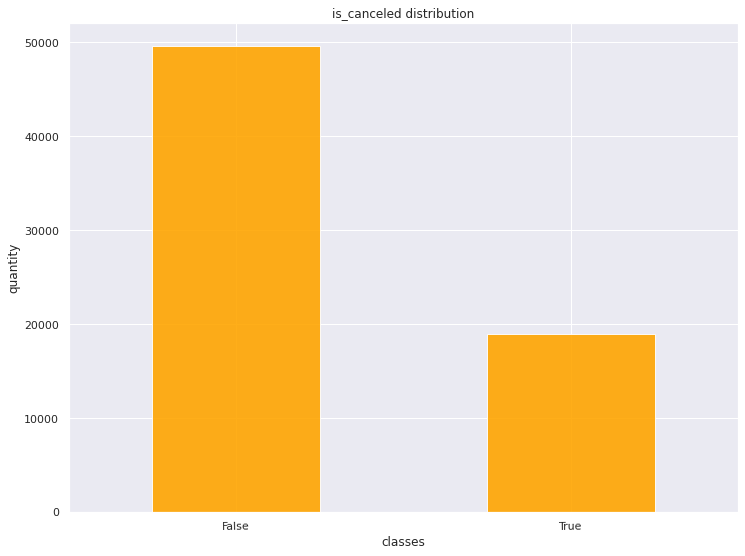

In [17]:
data['is_canceled'].value_counts().plot(kind='bar', title='is_canceled distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(12,9))

В колонке 'is_canceled' присутствует явный дисбаланс классов.

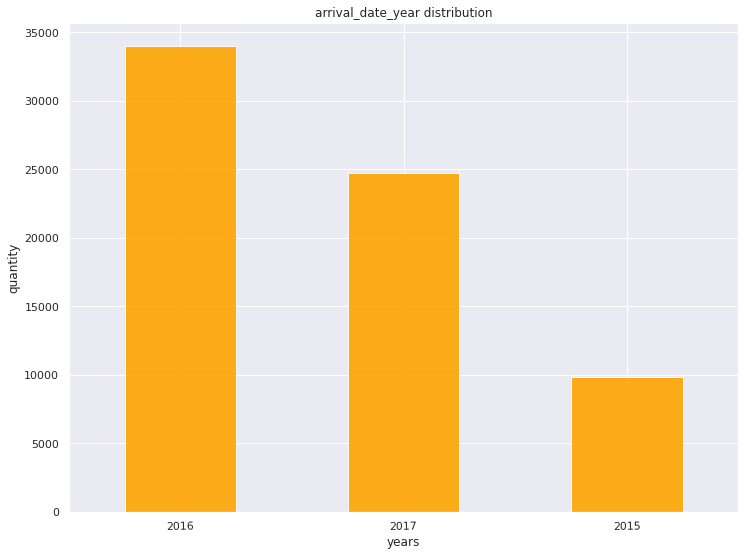

In [18]:
data['arrival_date_year'].value_counts().plot(kind='bar', title='arrival_date_year distribution', xlabel='years', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(12,9))

In [19]:
data['babies'].value_counts() 

0     67924
1       614
2         7
10        1
9         1
Name: babies, dtype: int64

In [20]:
data['adults'].value_counts() 

2    50835
1    13066
3     4396
0      229
4       21
Name: adults, dtype: int64

Text(0.5, 1.0, 'arrival_date_week_number distribution')

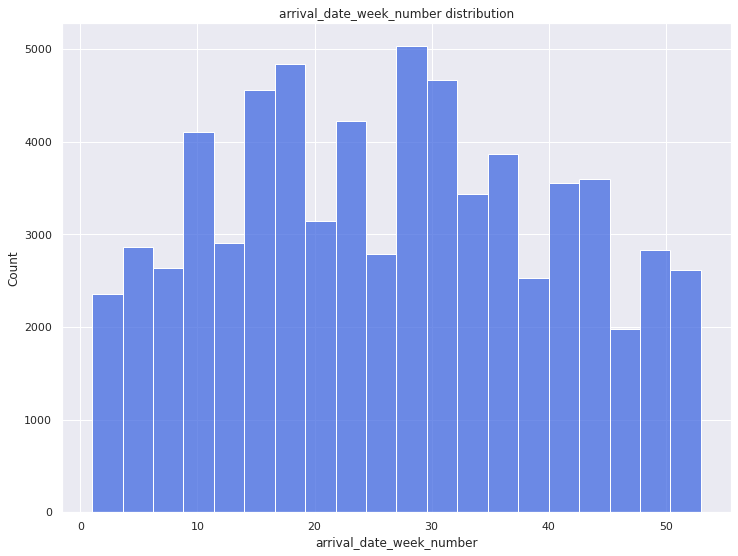

In [21]:
plt.figure(figsize=(12, 9))
sns.histplot(data['arrival_date_week_number'], bins=20, color='royalblue') 
plt.title('arrival_date_week_number distribution')

Данные в колонке arrival_date_week_number распределены практически нормально.

Text(0.5, 1.0, 'arrival_date_day_of_month distribution')

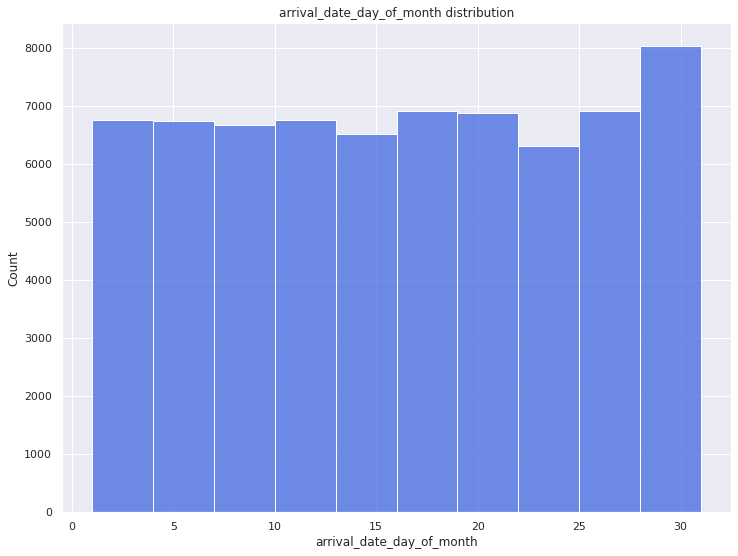

In [22]:
plt.figure(figsize=(12, 9))
sns.histplot(data['arrival_date_day_of_month'], bins=10, color='royalblue') 
plt.title('arrival_date_day_of_month distribution')

Данные в колонке arrival_date_day_of_month распределены практически равномерно.

Text(0.5, 1.0, 'booking_changes distribution')

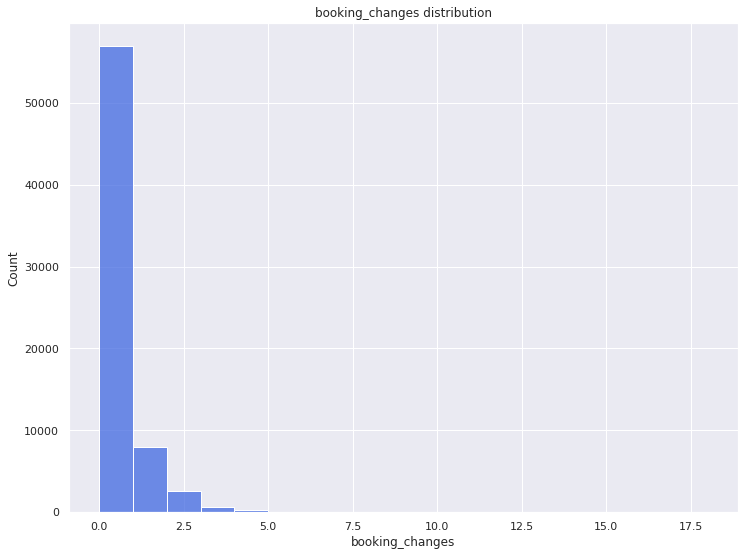

In [23]:
plt.figure(figsize=(12, 9))
sns.histplot(data['booking_changes'], color='royalblue') 
plt.title('booking_changes distribution')

В колонке booking_changes мы видим экспоненциальное распределение.

In [24]:
data['children'].value_counts() 

0    63198
1     3382
2     1946
3       21
Name: children, dtype: int64

В колонке country очень много стран с маленьким кол-вом посещений, поэтому сохраним топ-12 стран, а остальным присвоим значение 'others'

In [25]:
top_countries = ['PRT', 'FRA', 'GBR', 'ESP', 'DEU', 'ITA', 'IRL', 'BEL', 'BRA', 'NLD', 'USA', 'CHE']
data['country'] = data['country'].apply(lambda x: 'others' if x not in top_countries else x)

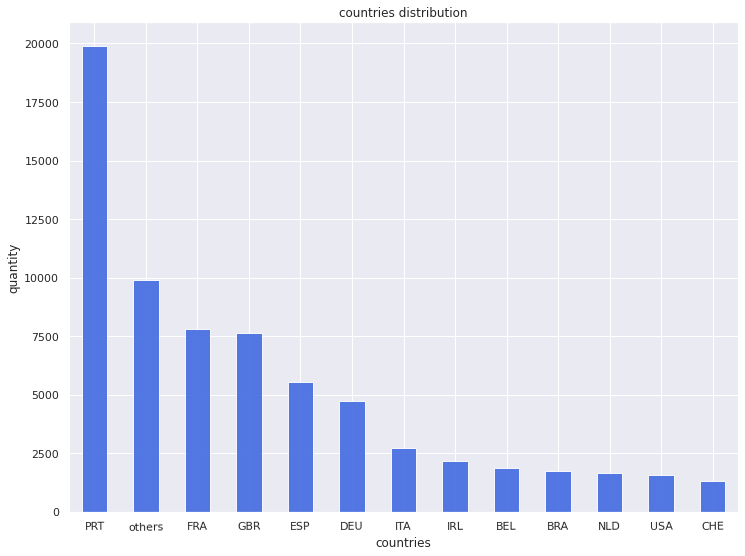

In [26]:
top13 = data['country'].value_counts()
top13.plot(kind='bar', title='countries distribution', xlabel='countries', 
                                     ylabel='quantity', rot=1, color='royalblue', alpha =0.9, figsize=(12,9))

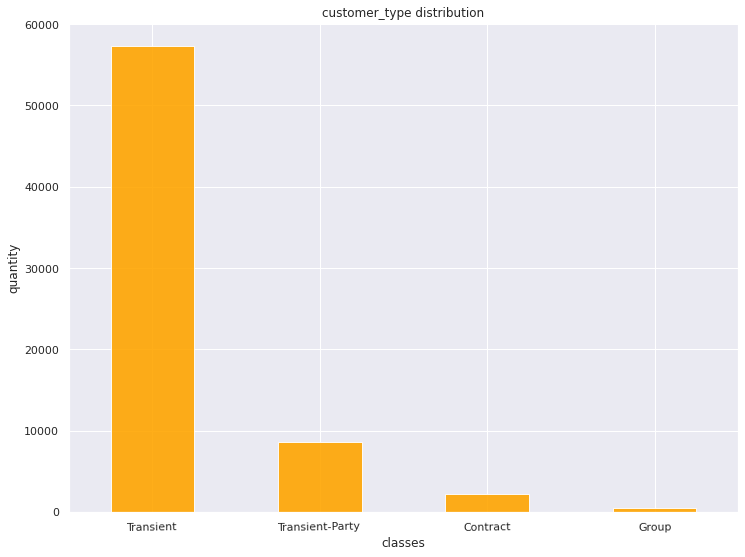

In [27]:
data['customer_type'].value_counts().plot(kind='bar', title='customer_type distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(12,9))

In [28]:
data['days_in_waiting_list'].value_counts()[:10] 

0     67892
63       45
15       21
87       18
44       18
48       16
4        15
34       13
38       12
77       11
Name: days_in_waiting_list, dtype: int64

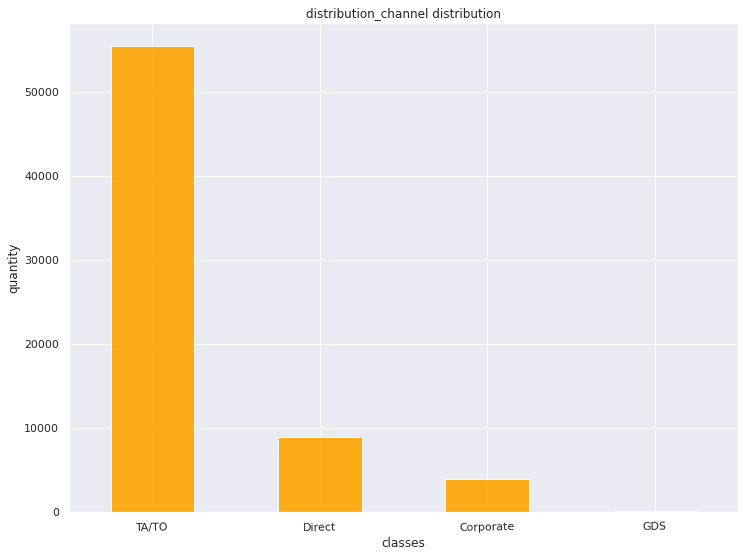

In [29]:
data['distribution_channel'].value_counts().plot(kind='bar', title='distribution_channel distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(12,9))

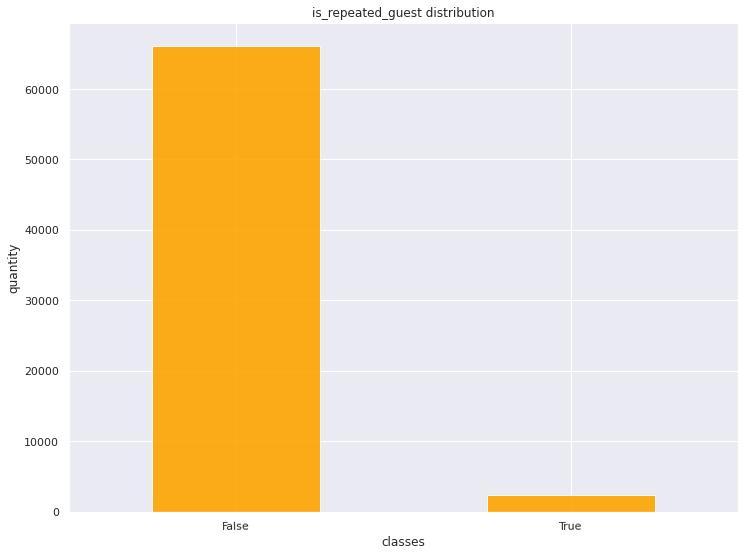

In [30]:
data['is_repeated_guest'].value_counts().plot(kind='bar', title='is_repeated_guest distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(12,9))

Text(0.5, 1.0, 'lead_time distribution')

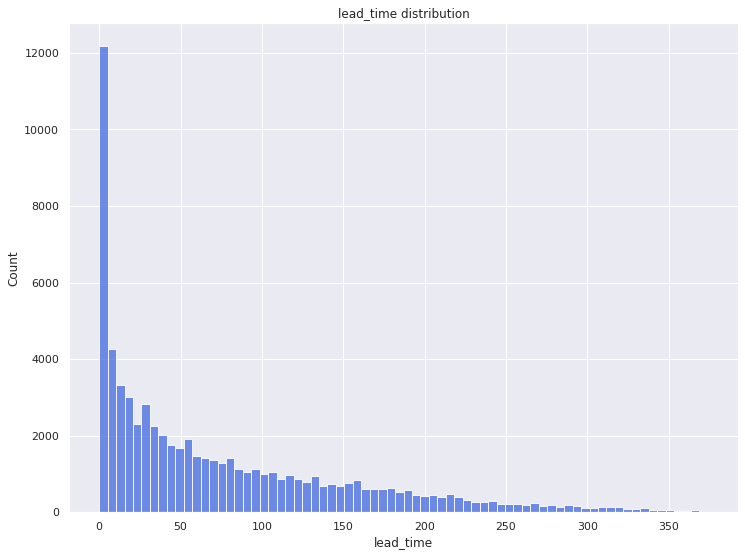

In [31]:
plt.figure(figsize=(12, 9))
sns.histplot(data['lead_time'], color='royalblue') 
plt.title('lead_time distribution')

В колонке lead_time данные распределены экспоненциально.

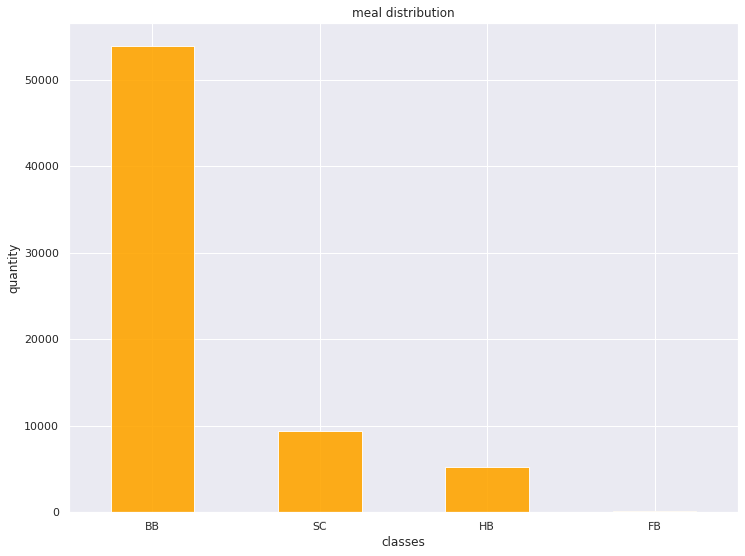

In [32]:
data['meal'].value_counts().plot(kind='bar', title='meal distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(12,9))

In [33]:
data['previous_bookings_not_canceled'].value_counts()[:15] 

0     66033
1      1005
2       411
3       221
4       172
5       135
6        93
7        67
8        49
9        42
10       42
11       32
12       30
13       22
14       21
Name: previous_bookings_not_canceled, dtype: int64

In [34]:
data['previous_cancellations'].value_counts()[:10] 

0     67173
1      1157
2        81
3        53
11       27
6        17
4        15
5        14
13        3
24        2
Name: previous_cancellations, dtype: int64

In [35]:
data['required_car_parking_spaces'].value_counts()[:10] 

0    63499
1     5027
2       17
3        2
8        2
Name: required_car_parking_spaces, dtype: int64

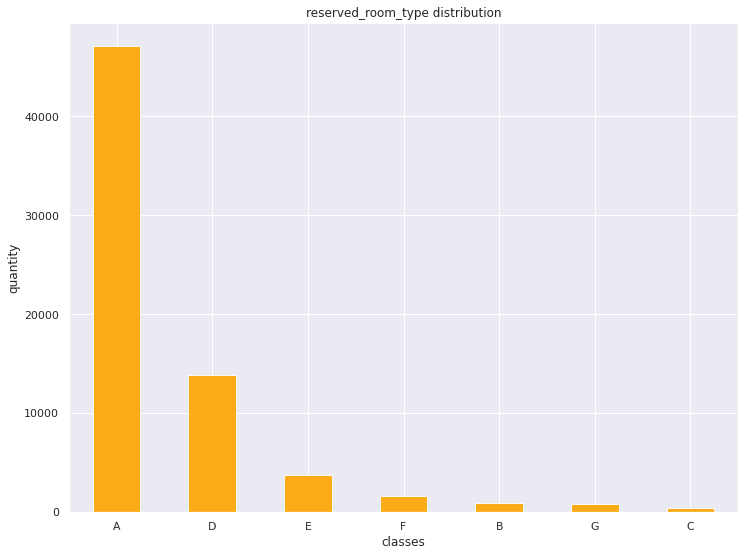

In [36]:
data['reserved_room_type'].value_counts().plot(kind='bar', title='reserved_room_type distribution', xlabel='classes', 
                                     ylabel='quantity', rot=1, color='orange', alpha =0.9, figsize=(12,9))

In [37]:
data['reserved_room_type'] = data['reserved_room_type'].map({'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6})

In [38]:
data['stays_in_weekend_nights'].value_counts()

0    28426
2    20407
1    19196
3      310
4      208
Name: stays_in_weekend_nights, dtype: int64

In [39]:
data['stays_in_week_nights'].value_counts()

1    18269
2    17541
3    14013
5     6800
4     6480
0     4638
6      806
Name: stays_in_week_nights, dtype: int64

In [40]:
data['total_nights'].value_counts() 

3     15510
1     13883
2     12985
4     11784
5      5677
7      5209
6      2474
8       680
9       183
10      162
Name: total_nights, dtype: int64

In [41]:
data['total_of_special_requests'].value_counts() 

0    33920
1    23275
2     9331
3     1781
4      213
5       27
Name: total_of_special_requests, dtype: int64

Проанализировав данные — удалим выбросы.

In [42]:
filter = ((data['adults']) != 0 & (data['adults'] < 4)) & \
         (data['previous_bookings_not_canceled'] < 8) & \
         (data['required_car_parking_spaces'] < 2) & \
         (data['total_of_special_requests'] < 5) & \
         (data['previous_cancellations'] < 4) & \
         (data['children'] < 3) & \
         (data['babies'] < 2)

In [43]:
data = data[filter]

В колонке days_in_waiting_list почти все значения равны 0. Пользы от этого никакой, поэтому удалим эту колонку.

In [44]:
data = data.drop('days_in_waiting_list', axis=1)

Теперь посмотрим люди из каких стран чаще отменяют бронь.

Посмотрим на "чемпионов" по отмене брони.

In [45]:
top13 = data.groupby('country')['is_canceled'].sum()

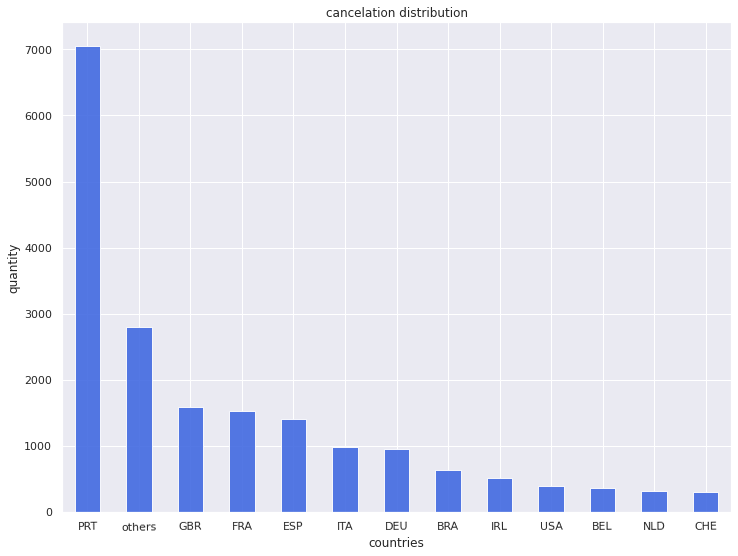

In [46]:
top13.sort_values(ascending=False).plot(kind='bar', title='cancelation distribution', xlabel='countries', 
                                     ylabel='quantity', rot=1, color='royalblue', alpha =0.9, figsize=(12,9))

Как мы видим на первом месте стоит Португалия.

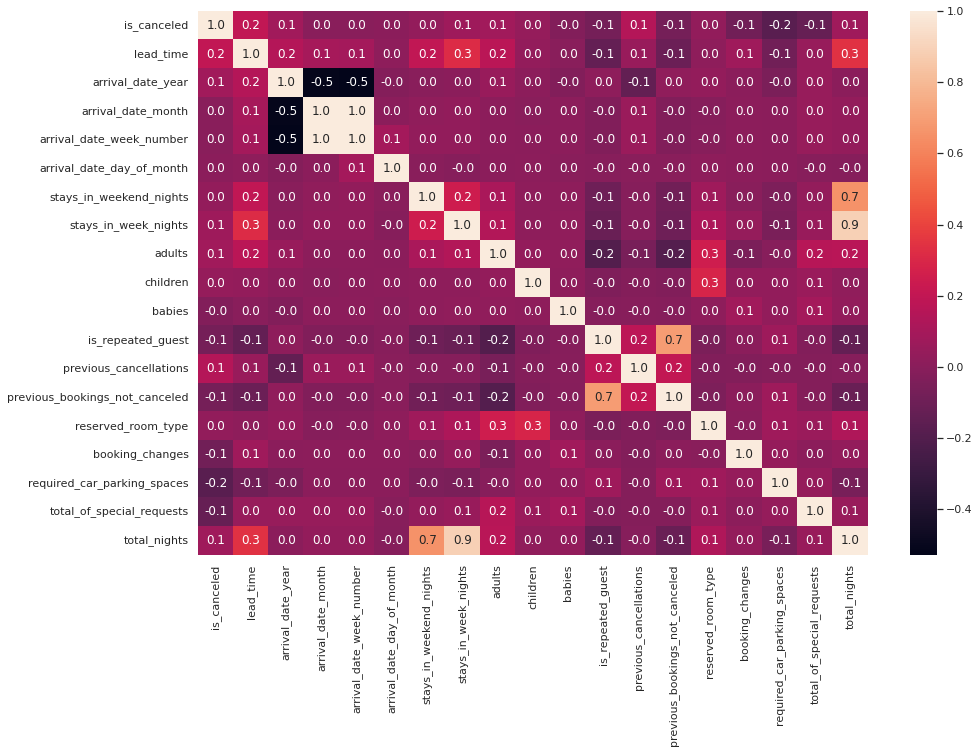

In [47]:
plt.figure(figsize=(15, 10))
sns.heatmap(data.corr(), annot=True, fmt=".1f")

Явных корреляций между целевой колонкой и остальными не было замечено. Заметна обратная корреляция между колонкой arrival_date_month и arrival_date_year. Также есть значительные корреляции между колонкой total_nights и колонками stays_in_weekend_nights, stays_in_week_nights. И еще есть значимая корреляция между колонками previous_bookings_not_canceled и is_repeated_guest.

между столбцами arrival_data_month и arrival_date_week_number 100% корреляция, удалим один из них.

In [48]:
data = data.drop(['arrival_date_week_number'], axis = 1)

# **Hotel profit calculation without ML**





Перед разработкой моделей посчитаем прибыль отеля за год.

Разобьем наши данные на два фрейма: train и test. Так как у нас доступно 3 года данных, то для обучения моделей будем использовать данные за 2015 и 2016 года, а для тестирования - данные за 2017 год. Прибыль будем считать именно на 2017 году.

In [49]:
train = data[data['arrival_date_year'] != 2017]
test = data[data['arrival_date_year'] == 2017]

Создадим колонку с датой.

In [50]:
test['date'] = test['arrival_date_year'].astype(str) + '-' + \
               test['arrival_date_month'].astype(str) + '-' + \
               test['arrival_date_day_of_month'].astype(str)
test['date'] = pd.to_datetime(test['date'])

In [51]:
test = test.reset_index(drop=True)

Напишем функцию, которая посчитает прибыль отеля.

In [52]:
def profit_counter(df, target = 'is_canceled', without_cancelation = False):
    
    spring_and_autumn = [3, 4, 5, 9, 10, 11]
    summer = [6, 7, 8]
    spring_and_autumn_coef = 1.2
    summer_coef = 1.4
    net_profit = np.array([])
    profit, cost = 0, 0
    subtotal = 0
    profit_with_coef = 0
    
    for i in range(len(df)):
        
        if df['reserved_room_type'][i] == 0:   # A
                profit = 1000
                cost = 400
        elif df['reserved_room_type'][i] == 1: # B
                profit = 800
                cost = 350
        elif df['reserved_room_type'][i] == 2: # C
                profit = 600
                cost = 350
        elif df['reserved_room_type'][i] == 3: # D
                profit = 550
                cost = 150
        elif df['reserved_room_type'][i] == 4: # E
                profit = 500
                cost = 150
        elif df['reserved_room_type'][i] == 5: # F
                profit = 450
                cost = 150
        else:                                  # G
                profit = 350
                cost = 150
        
        if df[target][i] == 0:    # если подтвердил
            for j in range(df['total_nights'][i]):
                
                dt = df['date'][i] + datetime.timedelta(days = j)
                
                if dt.month in spring_and_autumn:
                    profit_with_coef = profit * 1.2
                elif dt.month in summer:
                    profit_with_coef = profit * 1.4
                else:
                    profit_with_coef = profit
                
                subtotal += profit_with_coef
                
            subcost = math.ceil(df['total_nights'][i] / 2) * cost    
            net_profit = np.append(net_profit, subtotal - subcost)
            subtotal = 0
        else: # если отменил
            if without_cancelation == False:
                net_profit = np.append(net_profit, -cost)
            else:
                pass
    return net_profit

In [53]:
max_profit = profit_counter(test, without_cancelation = True).sum()
max_profit

45011340.0

In [54]:
real_profit = profit_counter(test).sum()
real_profit

42565840.0

In [55]:
max_profit - real_profit 

2445500.0

Чистая прибыль сети отелей за 2017 год без учета отмены брони составила 42 565 840 рублей, а с учетом — 45 011 340 рублей. Получается, что отель недозаработал 2 445 500 рублей.

# **Modeling**

Модель логистической регрессии, а также модель k ближайших соседей не могут корректно работать с категориальными признаками, закодированными порядковым способом, поэтому для них создадим отдельный датафрейм с преминением OHE к категориальным признакам.

Применим ohe

In [56]:
train_ohe = pd.get_dummies(train, drop_first=True)
test_ohe = pd.get_dummies(test, drop_first=True)

Применим label encoding.

In [57]:
columns = ['distribution_channel', 'customer_type', 'meal', 'country']
data = pd.concat([train, test])
enc = OrdinalEncoder()
data[columns] = enc.fit_transform(data[columns])
train = data[data['arrival_date_year'] != 2017]
test = data[data['arrival_date_year'] == 2017]

In [58]:
train = train.drop('date', axis=1)

Удалим колонку с годом из обоих фреймов, так как это колонка теперь неинформативна.

In [59]:
train = train.drop('arrival_date_year', axis=1)
test = test.drop('arrival_date_year', axis=1)

In [60]:
train.shape, test.shape

((43412, 21), (24399, 22))

In [61]:
train_ohe.shape, test_ohe.shape

((43412, 39), (24399, 40))

In [62]:
x_train = train.drop('is_canceled', axis=1)
y_train = train['is_canceled']

x_test = test.drop(['is_canceled', 'date'], axis=1)
y_test = test['is_canceled']

In [63]:
x_train_ohe = train_ohe.drop('is_canceled', axis=1)
y_train_ohe = train_ohe['is_canceled']

x_test_ohe = test_ohe.drop(['is_canceled', 'date'], axis=1)
y_test_ohe = test_ohe['is_canceled']

Протестируем различные модели.

In [64]:
model = LogisticRegression()
scores = cross_val_score(model, x_train_ohe, y_train_ohe, cv=4, scoring='roc_auc')
print(scores)
print('avg auc-roc:', sum(scores) / len(scores))

[0.71303976 0.4602546  0.69194732 0.72389005]
avg auc-roc: 0.6472829331702628


In [65]:
model = KNeighborsClassifier(n_neighbors = 2)
scores = cross_val_score(model, x_train_ohe, y_train_ohe, cv=4, scoring='roc_auc')
print(scores)
print('avg auc-roc:', sum(scores) / len(scores))

[0.56193123 0.4011334  0.38253446 0.47058927]
avg auc-roc: 0.4540470916594924


In [66]:
model = RandomForestClassifier(random_state=67)
scores = cross_val_score(model, x_train, y_train, cv=4, scoring='roc_auc')
print(scores)
print('avg auc-roc:', sum(scores) / len(scores))

[0.80905919 0.42817667 0.36010307 0.65459245]
avg auc-roc: 0.5629828436286787


In [67]:
model = XGBClassifier(random_state=67, tree_method='gpu_hist')
scores = cross_val_score(model, x_train, y_train, cv=4, scoring='roc_auc')
print(scores)
print('avg auc-roc:', sum(scores) / len(scores))

[0.84647102 0.4961889  0.45878819 0.70503201]
avg auc-roc: 0.6266200304621953


У нас два претендента: лог. регрессия и xgboost. Формально у логист. регриссии результат в среднем лучше, но у xgboost есть один очень высокий результат. Я предполагаю, что если обучить эти модели на полном наборе train и потом проверить на наборе test, то у xgboost будет результат лучше. Проверим эту гипотезу.

Для начала подберем гиперпараметры.

**Hyperparameter tuning**

In [68]:
xgb_params = {
    'learning_rate': np.arange(0.05, 0.31, 0.05),
    'max_depth': np.arange(3, 9, 1, dtype=int),
    'min_child_weight': np.arange(1, 8, 1, dtype=int),
    'colsample_bytree': np.arange(0.3, 0.8, 0.1),
    'subsample': [0.8, 1],
    'n_estimators': np.arange(100, 500, 25)
}

In [69]:
log_reg_params = {
    'C': [10 ** -2, 10 ** -1, 10, 10 ** 2, 10 ** 2], 
    'solver' : ['lbfgs', 'liblinear', 'saga']
    }

In [70]:
clf = GridSearchCV(model,log_reg_params, scoring = 'roc_auc')
clf.fit(x_train_ohe, y_train_ohe)
clf.best_params_

{'C': 0.01, 'solver': 'lbfgs'}

In [71]:
model = XGBClassifier(random_state=67, tree_method='gpu_hist')
rs_model = RandomizedSearchCV(model, param_distributions=xgb_params, 
                              scoring='roc_auc', n_jobs=-1, cv=3, 
                              verbose=3, n_iter=50, random_state=67)
rs_model.fit(x_train, y_train)
rs_model.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'colsample_bytree': 0.3,
 'learning_rate': 0.05,
 'max_depth': 4,
 'min_child_weight': 6,
 'n_estimators': 250,
 'subsample': 1}

Проверим модели с подобранными гиперпараметрами на тестовых данных.

In [72]:
model = clf.best_estimator_
model.fit(x_train_ohe, y_train_ohe)
roc_auc_score(y_test_ohe, model.predict_proba(x_test_ohe)[:, 1])

0.7765706298994766

In [73]:
model = rs_model.best_estimator_
model.fit(x_train, y_train)
roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])

0.7830876779842506

Действительно, как я и предполагал, xgboost обогнал логист. регрессию, при обучении на всем наборе train.

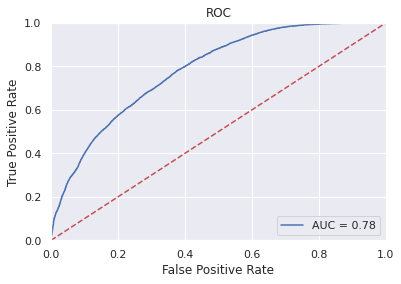

In [74]:
probs = model.predict_proba(x_test)
preds = probs[:,1]
fpr, tpr, threshold = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)

plt.title('ROC')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

# **Hotel profit calculation with ML**

In [75]:
predictions = model.predict(x_test)

In [76]:
test['predict'] = predictions 

Напишем функцию расчета прибыли отеля с использованием xgboost модели.

Прибыль после внедрения депозитов зависит как от истинных, так и от предсказанных значений целевого признака.

In [77]:
def advanced_profit_counter(df):
    
    spring_and_autumn = [3, 4, 5, 9, 10, 11]
    summer = [6, 7, 8]
    spring_and_autumn_coef = 1.2
    summer_coef = 1.4
    cost = 0
    profit = 0
    profit_with_ml = np.array([])
    profit_with_coef = 0
    subtotal = 0
    
    for i in range(len(df)):
        
        if df['reserved_room_type'][i] == 0:   # A
                profit = 1000
                cost = 400
        elif df['reserved_room_type'][i] == 1: # B
                profit = 800
                cost = 350
        elif df['reserved_room_type'][i] == 2: # C
                profit = 600
                cost = 350
        elif df['reserved_room_type'][i] == 3: # D
                profit = 550
                cost = 150
        elif df['reserved_room_type'][i] == 4: # E
                profit = 500
                cost = 150
        elif df['reserved_room_type'][i] == 5: # F
                profit = 450
                cost = 150
        else:                                  # G
                profit = 350
                cost = 150
                
        if (df['is_canceled'][i] == 0 and df['predict'][i] == 0) or (df['is_canceled'][i] == 0 and df['predict'][i] == 1):
            
            for j in range(df['total_nights'][i]):
                
                dt = df['date'][i] + datetime.timedelta(days = j)
                
                if dt.month in spring_and_autumn:
                    profit_with_coef = profit * 1.2
                elif dt.month in summer:
                    profit_with_coef = profit * 1.4
                else:
                    profit_with_coef = profit
                
                subtotal += profit_with_coef
                
            subcost = math.ceil(df['total_nights'][i] / 2) * cost    
            profit_with_ml = np.append(profit_with_ml, subtotal - subcost)
            subtotal = 0
            
        elif df['is_canceled'][i] == 1 and df['predict'][i] == 0:
            
            profit_with_ml = np.append(profit_with_ml, -cost)
            
        else: # canceled == 1 and predicted == 1
            dt = df['date'][i]
            multiplier = 1
            if dt.month in spring_and_autumn:
                multiplier = 1.2
            elif dt.month in summer:
                multiplier = 1.4
                    
            profit_with_ml = np.append(profit_with_ml, (profit*multiplier + cost) * 0.8 - cost)
            
    return profit_with_ml

In [78]:
ml_res = advanced_profit_counter(test).sum()
ml_res

45216672.0

In [79]:
net_profit_difference = ml_res - real_profit
net_profit_difference

2650832.0

До внедрения модели годовой чистая прибыль сети отелей составляла 42 565 840 рублей в год, а с внедрением модели — 45 361 312 рублей. То есть модель дополнительно заработала 2 650 832 рублей за год.

# **Results**

Теперь приступим к анализу нашей модели. Для этого воcпользуемся библиотекой shap.

In [80]:
x_train_and_test = pd.concat([x_train, x_test])
y_train_and_test = pd.concat([y_train, y_test])

In [81]:
model = XGBClassifier(colsample_bytree=0.3,
                      min_child_weight=6,
                      learning_rate=0.05,
                      n_estimators=250,
                      random_state=67, 
                      max_depth=4,
                      subsample=1,
                      )
model.fit(x_train_and_test, y_train_and_test)

XGBClassifier(colsample_bytree=0.3, learning_rate=0.05, max_depth=4,
              min_child_weight=6, n_estimators=250, random_state=67)

In [82]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train_and_test)

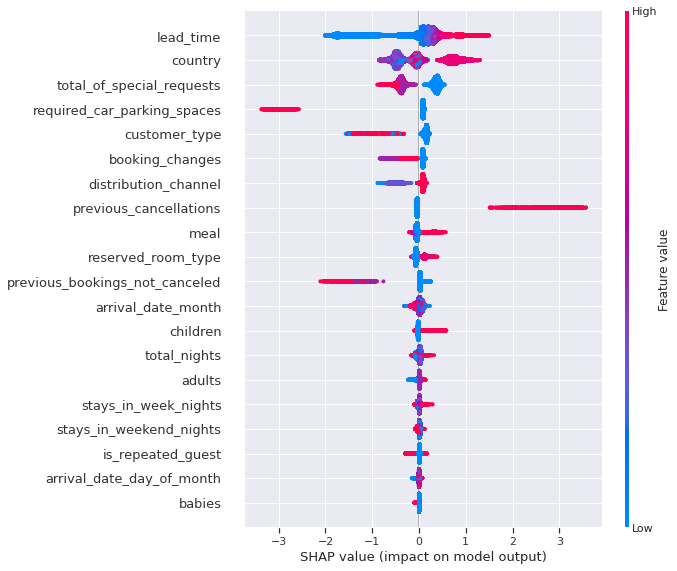

In [83]:
shap.summary_plot(shap_values, x_train_and_test)

На основе анализа данного графика опишем портет "надежных" и "ненадежных" клиентов.

**"Надежный" клиент:**

  Вместе с бронированием номера такой клиент также бронирует парковочные места. Также у такого клиента большое кол-во прошлых заказов, которые не были отменены. Еще у такого клиента маленькое кол-во дней между датой бронирования и датой прибытия.

**"Ненадежный" клиент:**

У такого клиента были отмены предыдущих заказов,также у него большое кол-во дней между датой бронирования и датой прибытия. Еще у такого клиента есть несколько детей. Также у такого клиента маленькое кол-во специальных меток.

Теперь посмотрим на значимость фичей.

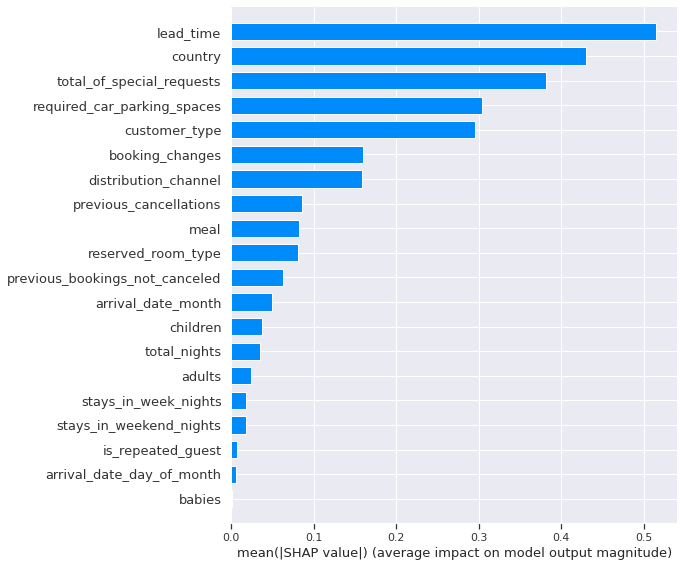

In [84]:
shap.summary_plot(shap_values, x_train_and_test, plot_type="bar")

По графику видно что топ-3 самых значимых параметра для модели: кол-во дней между датой бронирования и датой прибытия, страна и кол-во специальных отметок.

# **Conclusion**

**Была проделана большая работа. Данные были изучены и предобработаны, был проведен исследовательский анализ данных. Была посчитана прибыль отеля за год без внедрения модели и с внедрением модели. Было протестировано несколько различных моделей и у лучших из них был произведен подбор гиперпараметров. Были описаны портреты "надежных" и "ненадежных" клиентов, а так же были выявлены самые значимые фичи для модели. Удалось увеличить прибыль сети отелей на  2 650 832 рублей в год, что значительно превосходит бюджет на разработку модели.**